<a href="https://colab.research.google.com/github/WahyuKhairi06/DeepLearning-WahyuKhairi-2311531009/blob/main/Tugas%20Besar/2311531009_Wahyu_Khairi_ProgramTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Klasifikasi Kepatuhan Penggunaan Alat Pelindung Diri (PPE) pada Pekerja Konstruksi Menggunakan Transfer Learning MobileNetV2**

In [ ]:
# Library utama
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Colab
from google.colab import drive
from google.colab import files


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/PPE_klasifikasi/worksite_safety.zip'
extract_path = '/content/worksite_dataset'

print("Mengekstrak dataset...")
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print("Ekstraksi selesai.")


Mengekstrak dataset...
Ekstraksi selesai.


In [ ]:
base_dir = extract_path

train_dir = os.path.join(base_dir, 'Worksite-Safety-Monitoring-Dataset/train')
valid_dir = os.path.join(base_dir, 'Worksite-Safety-Monitoring-Dataset/valid')
test_dir  = os.path.join(base_dir, 'Worksite-Safety-Monitoring-Dataset/test')

print("Isi folder train :", os.listdir(train_dir))
print("Isi folder valid :", os.listdir(valid_dir))
print("Isi folder test  :", os.listdir(test_dir))


Isi folder train : ['safe', 'unsafe']
Isi folder valid : ['safe', 'unsafe']
Isi folder test  : ['safe', 'unsafe']


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Bekukan seluruh layer pretrained
for layer in base_model.layers[-30:]:
    layer.trainable = False

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 861,569 (3.29 MB)

 Non-trainable params: 1,560,512 (5.95 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5740 - loss: 0.7448 - val_accuracy: 0.6100 - val_loss: 0.6400
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 548ms/step - accuracy: 0.6753 - loss: 0.6093 - val_accuracy: 0.7350 - val_loss: 0.5553
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 549ms/step - accuracy: 0.7421 - loss: 0.5325 - val_accuracy: 0.7500 - val_loss: 0.5068
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.7785 - loss: 0.4580 - val_accuracy: 0.7950 - val_loss: 0.4754
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 535ms/step - accuracy: 0.8403 - loss: 0.3817 - val_accuracy: 0.7800 - val_loss: 0.4436
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.8739 - loss: 0.3251 - val_accuracy: 0.8150 - val_loss: 0.4224
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.8681 - loss: 0.3100 - val_accuracy: 0.8550 - val_loss: 0.3768
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 543ms/step - accuracy: 0.9075 - loss: 0.2377 - val_accurac

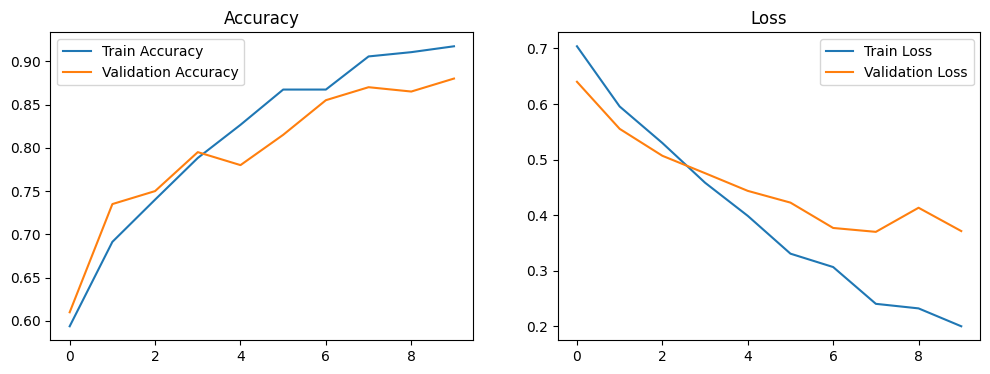

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
pred_probs = model.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

print(classification_report(
    y_true, y_pred,
    target_names=['Safe', 'Unsafe']
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 816ms/step
              precision    recall  f1-score   support

        Safe       0.86      0.84      0.85       100
      Unsafe       0.84      0.86      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



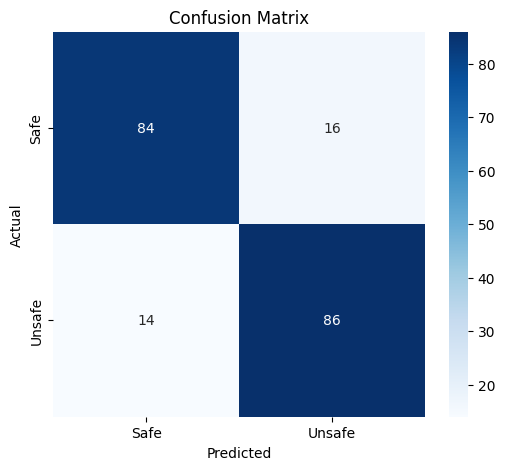

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Safe', 'Unsafe'],
    yticklabels=['Safe', 'Unsafe']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **Pengujian Pada Gambar nyata**

Saving tes gambar 2.jpg to tes gambar 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


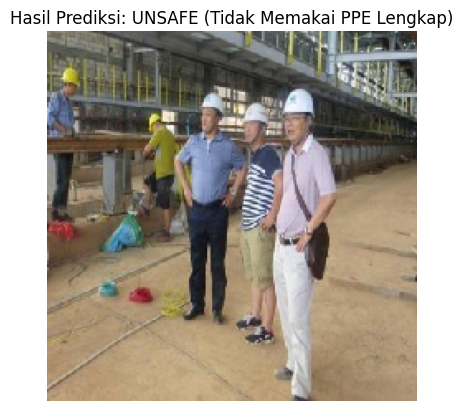

In [ ]:
uploaded = files.upload()

for file_name in uploaded.keys():
    img = image.load_img(file_name, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]

    if pred > 0.5:
        label = "UNSAFE (Tidak Memakai PPE Lengkap)"
    else:
        label = "SAFE (Memakai PPE Lengkap)"

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Hasil Prediksi: {label}")
    plt.show()


Saving test gambar.jpg to test gambar.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


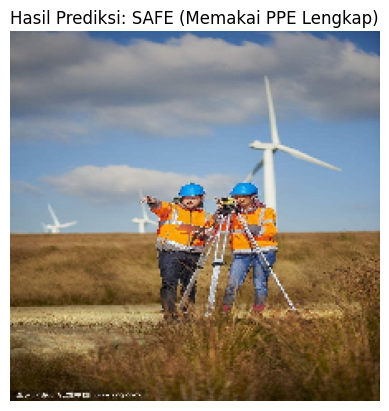

In [ ]:
uploaded = files.upload()

for file_name in uploaded.keys():
    img = image.load_img(file_name, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]

    if pred > 0.5:
        label = "UNSAFE (Tidak Memakai PPE Lengkap)"
    else:
        label = "SAFE (Memakai PPE Lengkap)"

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Hasil Prediksi: {label}")
    plt.show()
